In [10]:
import time
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric import transforms
from torch_geometric.nn import GAE

from pathlib import Path

In [8]:
import seaborn as sns
import pickle

In [6]:
sim_value = "80_1"
fig_folder=f"figs_{sim_value}"

In [25]:
Path(fig_folder).mkdir(parents=True, exist_ok=True)

In [27]:
#f"topic_co_occurance_graph_{sim_value}.gpickle"

In [28]:
def data_load(embed, size):
    embed_size = size
    graph      = nx.read_gpickle(f"topic_co_occurance_graph_{sim_value}.gpickle") #change
    nx.set_node_attributes(graph, values = embed, name='x')
    for node in graph.nodes:
        node_dict = graph.nodes[node]
        if node_dict.get('x') is None:
            node_dict['x']= [0]*embed_size
    return graph

In [4]:
def load_obj(name):
    '''
    name: Filename
    '''
    with open(name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [30]:
#Data(x=[268701, 10], val_pos_edge_index=[2, 12971], test_pos_edge_index=[2, 25942], train_pos_edge_index=[2, 441028])

In [31]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [32]:
def train():
    model.train()
    optimizer.zero_grad()
    z    = model.encode(x,train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [33]:
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [34]:
def save_obj(obj, name):
    '''
    obj : Dictionary
    name : Filename to save
    '''
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=4)#
    print("saved")

In [35]:
#secibert_embeddings  = load_obj('combined_reduced_tsne_embed')

In [36]:
#a = data_load(secibert_embeddings, 400)

In [37]:
if __name__=="__main__":
    # parameters
    embed_size   = 400
    out_channels = 100
    num_features = embed_size
    epochs       = 300

    secibert_embeddings  = load_obj('combined_reduced_tsne_embed')
    graph  = data_load(secibert_embeddings, embed_size)
    data   = from_networkx(graph)
    

    # model
    model = GAE(GCNEncoder(num_features, out_channels))

    # move to GPU (if available)
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    model  = model.to(device, dtype=torch.double)
    x = data.x.to(device, dtype=torch.double)
    train_pos_edge_index = data.edge_index.to(device)

    # inizialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    loss_values = []
    for epoch in range(1, epochs + 1):
        loss = train()
        loss_values.append(loss)
    new_embedding = model.encode(x, train_pos_edge_index)
    new_embedding = new_embedding.cpu().detach().numpy()
    nodes = list(graph.nodes)
    gcn_embed = dict(zip(nodes, new_embedding))
    save_obj(gcn_embed, f"gcn_embeddings_{sim_value}") #change

saved


In [38]:
# secibert_embeddings  = load_obj('combined_reduced_tsne_embed')
# graph  = data_load(secibert_embeddings, 400)

In [39]:
# data   = from_networkx(graph)

In [40]:
#loss_values

In [41]:
print(f"Min loss: {min(loss_values)}")

Min loss: 0.7326766798555024


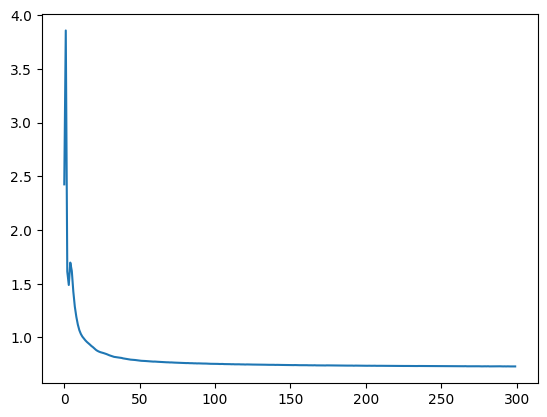

In [15]:
plt.plot(loss_values)

In [1]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
top = 10 

In [11]:
embedding_dict = load_obj(f"gcn_embeddings_{sim_value}") #change
embedding      = np.array(list(embedding_dict.values()))
embedding_id   = np.array(list(embedding_dict.keys()))

In [15]:
%store -r topic_with_value
%store -r filtered_groups
%store -r group_head_id

In [46]:
%%time
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
embs_1 = tsne.fit_transform(embedding)
%store embs_1

/home/dhananjay/final_group_influence/venv3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dhananjay/final_group_influence/venv3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Stored 'embs_1' (ndarray)
CPU times: user 5h 51min 10s, sys: 1min 10s, total: 5h 52min 21s
Wall time: 10min 25s


In [12]:
%store -r embs_1

In [19]:
# def plot_bg(bg_alpha=.1, figsize=(13, 9), emb_2d=None):
#     if emb_2d is None:
#         emb_2d = embs
#     fig, ax = plt.subplots(figsize=figsize)
#     X = emb_2d[:, 0]
#     Y = emb_2d[:, 1]
#     ax.scatter(X, Y, alpha=bg_alpha, marker="o", s=10, color="gray")
#     return ax

In [20]:
# def plot_with_annotations(label_indices, colors=None, labels=None, alpha=1, **kwargs):
#     ax = plot_bg1(**kwargs)
#     for indices, label, color in zip(label_indices, labels, colors):
#         print(indices)
#         print(label)

#         Xlabeled = kwargs["emb_2d"][indices, 0]
#         Ylabeled = kwargs["emb_2d"][indices, 1]
# #         ax.scatter(Xlabeled, Ylabeled, alpha=alpha, label=label, marker='1',
# #                        s=200,color=color
# #                       )
#         ax.plot(Xlabeled, Ylabeled,'--', alpha=alpha, label=label, marker='1', color=color, linewidth=1)
#     ax.legend()    
# #     if text:
# #         # TODO: Add abbreviated title column
# #         titles = mainstream_movies.loc[label_indices, 'title'].values
# #         texts = []
# #         for label, x, y in zip(titles, Xlabeled, Ylabeled):
# #             t = ax.annotate(label, xy=(x, y))
# #             texts.append(t)
# #         adjust_text(texts, 
# #                     #expand_text=(1.01, 1.05),
# #                     arrowprops=dict(arrowstyle='->', color='red'),
# #                    )
#     return ax

In [48]:
def plot_bg1(bg_alpha=.5, figsize=(13, 9), data_df=None):
    global num_clusters
    if data_df is None:
        data_df = df
    u_labels = range(0, num_clusters)
    fig, ax = plt.subplots(figsize=figsize)
    #plotting the results:
    for i in u_labels:
        ax.scatter(data_df[data_df['label']==i]["component1"],data_df[data_df['label']==i]["component2"], label=i,
                   alpha=bg_alpha, marker="o", s=2)
    ax.legend()  #markerscale=1
    #plt.savefig(f"{fig_folder}/group_co-topic_cluster.pdf")
    #ax.show()
    return ax

In [49]:
def plot_with_annotations1(label_indices, colors=None, labels=None, alpha=1, **kwargs):
    ax = plot_bg1(**kwargs)
    for indices, label, color in zip(label_indices, labels, colors):
        #print(indices)
        #print(label)
        #print(kwargs["data_df"]["component1"].values)
        Xlabeled = kwargs["data_df"]["component1"].values[indices]
        Ylabeled = kwargs["data_df"]["component2"].values[indices]
        
        ax.plot(Xlabeled, Ylabeled,'--', alpha=alpha, label=label, marker='o', color=color, 
                linewidth=1, markersize=9)
    ax.legend()    
    return ax

In [50]:
%store -r persistent_res_kl
%store -r anti_persistent_res_kl
%store -r persistent_res_tau
%store -r anti_persistent_res_tau

In [51]:
per_kl_idd    = persistent_res_kl
anti_kl_idd   = anti_persistent_res_kl
per_tau_idd   = persistent_res_tau
anti_tau_idd  = anti_persistent_res_tau

res_type_kl   = [per_kl_idd[:top], anti_kl_idd[:top]]
res_type_tau  = [per_tau_idd[:top], anti_tau_idd[:top]]

index_kl      = [[np.where(embedding_id == i)[0][0] for i in idd if np.where(embedding_id == i)[0].size] 
                 for idd in res_type_kl] 
index_tau     = [[np.where(embedding_id == i)[0][0] for i in idd if np.where(embedding_id == i)[0].size] 
                 for idd in res_type_tau]

In [52]:
%store -r persistent_res_kl1
%store -r anti_persistent_res_kl1
%store -r persistent_res_tau1
%store -r anti_persistent_res_tau1

In [53]:
#after elbow point selection, visualization of persistent and not persistent groups
per_kl_idd1   =  persistent_res_kl1
anti_kl_idd1  =  anti_persistent_res_kl1

per_tau_idd1  =  persistent_res_tau1
anti_tau_idd1 =  anti_persistent_res_tau1

res_type_kl1  =  [per_kl_idd1[:top], anti_kl_idd1[:top]]
res_type_tau1 =  [per_tau_idd1[:top], anti_tau_idd1[:top]]

index_kl1     =  [[np.where(embedding_id == i)[0][0] for i in idd if np.where(embedding_id == i)[0].size] 
                  for idd in res_type_kl1]
index_tau1    =  [[np.where(embedding_id == i)[0][0] for i in idd if np.where(embedding_id == i)[0].size] 
                  for idd in res_type_tau1]

In [54]:
labels_kl  =  ["Persistent_KL", "Antipersistent_KL"]
labels_tau =  ["Persistent_MJC", "Antipersistent_MJC"]
colors     =  ["blue","black"]    #,"green", "cyan"

In [55]:
scaler           = MinMaxScaler()
scaled_embedding = scaler.fit_transform(embedding)

In [56]:
kmeans_kwargs = {
 "init": "random",
 "n_init": 10,
 "max_iter": 300,
 "random_state": 42,
 }
num_of_topics = 25

In [57]:
sse= []
for k in range(1, num_of_topics):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_embedding)
    sse.append(kmeans.inertia_)

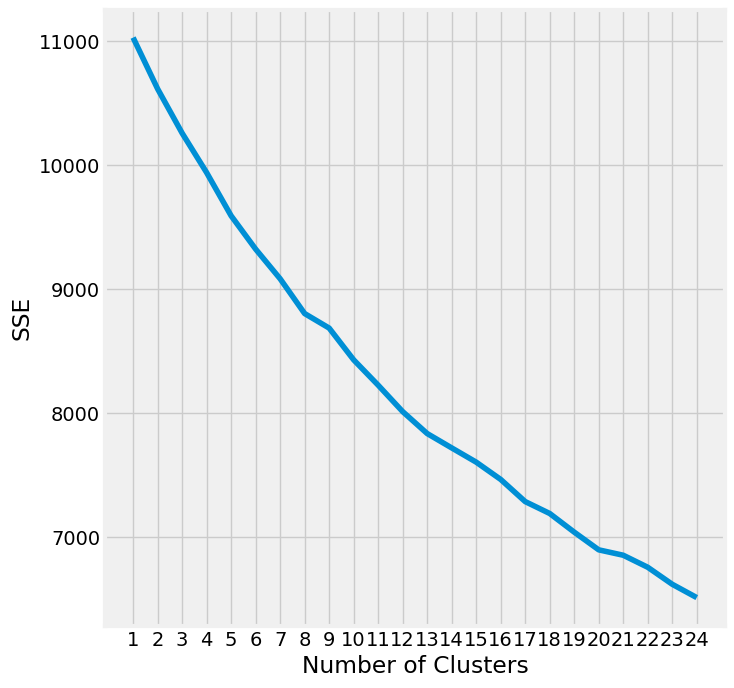

In [58]:
plt.figure(figsize=(8,8))
plt.style.use("fivethirtyeight")
plt.plot(range(1, num_of_topics), sse)
plt.xticks(range(1, num_of_topics))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [30]:
#clustering = SpectralClustering(n_clusters=3,assign_labels='discretize',random_state=0).fit(embedding)

In [59]:
kl = KneeLocator(range(1, num_of_topics), sse, curve="convex", direction="decreasing")
num_clusters = kl.elbow
print(num_clusters)

12


In [18]:
num_clusters=12

In [19]:
#clustering = SpectralClustering(n_clusters=3,assign_labels='discretize',random_state=0).fit(embedding)

In [20]:
kmeans = KMeans(
     init="random",
     n_clusters=num_clusters,
     n_init=10,
     max_iter=300,
     random_state=42
 )
kmeans.fit(embedding)

KMeans(init='random', n_clusters=12, random_state=42)

In [63]:
#embedding_id

In [21]:
grp_member = [filtered_groups[head] for head in embedding_id]

In [22]:
df = pd.DataFrame()
df["grp_id"]     = embedding_id
df["grp_member"] = grp_member
df['component1'] = embs_1[:,0]
df['component2'] = embs_1[:,1]
df['label']      = kmeans.labels_
df_copy = df.copy()

In [34]:
%store -r group_top_topics1

In [92]:
%store -r lda_model
%store -r id2word
%store -r prepare_text_for_lda

In [96]:
[id2word[idx[0]] for idx in lda_model.get_topic_terms(18)]

['problem',
 'optim',
 'variat',
 'invers',
 'program',
 'condit',
 'algorithm',
 'convex',
 'linear',
 'regular']

In [95]:
[id2word[idx[0]] for idx in lda_model.get_topic_terms(14)]

['equat',
 'solut',
 'differenti',
 'order',
 'problem',
 'nonlinear',
 'boundari',
 'exist',
 'system',
 'valu']

In [109]:
group_top_topics1[695]

[21, 0, 24, 3, 5]

In [36]:
group_top_topics1[75796]

[18, 12, 4, 11, 1]

In [97]:
df_copy.sample(10)

,grp_id,grp_member,component1,component2,label
3292,12402,"(92625, 55526, 103386, 112742, 162025, 55525, ...",133.719513,-44.044228,5
2325,9055,"(53427, 9147, 9078, 101176, 11464, 9936, 9938,...",83.564140,70.179359,5
2768,117857,"(100092, 172576, 233394, 160287, 142202, 14218...",97.087608,84.753036,11
12571,129223,"(272469, 211957, 200477, 258302, 265747)",-25.457722,119.563271,5
7613,120294,"(116147, 116731, 119964, 120955, 120953, 12095...",134.432861,-79.310921,1
8552,75796,"(198046, 186800, 75938, 90599, 131929)",6.913438,-95.377609,6
2151,695,"(109147, 49189, 47901, 49187, 144547, 49188, 1...",89.732262,86.051071,11
9229,122517,"(122530, 260541, 182579, 170360, 170359, 239063)",-150.428711,30.476263,5
5154,30467,"(7653, 14740, 21691, 131683, 131684, 128006, 1...",49.571022,-117.415039,5
6301,33913,"(33263, 79330, 141441, 99893, 77704, 141438, 5...",12.335121,45.753990,5


In [118]:
df_copy[df_copy["grp_id"]==13]

,grp_id,grp_member,component1,component2,label
267,13,"(59464, 59467, 59466, 59461, 52007, 16021, 409...",120.706062,-35.3647,5


In [141]:
df_copy[df_copy["grp_id"]==57859]

,grp_id,grp_member,component1,component2,label
14591,57859,"(185832, 175613, 187739, 185829, 231782, 23787...",35.379269,30.605288,5


In [69]:
group_top_topics1[22854]

[9, 16, 17, 0, 5]

In [ ]:
258-- cluster5 -13

In [38]:
#df[["grp_id","grp_member","label"]].values[50]

In [67]:
def get_cluster_info(advid):
    global df_copy
#advid= 8038
    grp_members = df_copy[df_copy["grp_id"]==advid]["grp_member"].values[0]
    member_labels = df_copy[df_copy["grp_id"].isin(grp_members)][["label","grp_id"]].groupby(["label"])['grp_id'].apply(list).reset_index(name='group_members').copy()
    if member_labels.empty:
        members_info=()
    else:
        member_labels["members_count"] = member_labels["group_members"].apply(lambda x: len(x))
        members_info= tuple(zip(member_labels["label"], member_labels["group_members"], member_labels["members_count"]))
    return members_info

In [68]:
def get_migration_info(df):
    cluster_migration = dict(zip(df["grp_id"], df["cluster_migration2"]))
    head_label        = dict(zip(df["grp_id"], df["label"]))
    inter_cluster = {}
    for idd in df["grp_id"].values:
        label = head_label[idd]
        if label in inter_cluster:
            prev =  inter_cluster[label]
            curr =  np.array(cluster_migration[idd])
            inter_cluster[label] =  prev+curr
        else:
            inter_cluster[label] = np.array(cluster_migration[idd])
    inter_cluster1 = dict(sorted(inter_cluster.items(), key=lambda x: x[0]))
    return inter_cluster1

In [69]:
def get_migration_info1(df):
    cluster_migration = dict(zip(df["grp_id"], df["lbl_mem_id1"]))
    head_label        = dict(zip(df["grp_id"], df["label"]))
    inter_cluster = {}
    for idd in df["grp_id"].values:
        label = head_label[idd]
        if label in inter_cluster:
            inter_cluster[label]["head"].append(idd)
            prev =  inter_cluster[label]["mem_info"]
            curr =  cluster_migration[idd]
            inter_cluster[label]["mem_info"] = [i+j for i,j in zip(prev, curr)]
        else:
            inter_cluster[label] ={"head":[idd], "mem_info":cluster_migration[idd]}
    inter_cluster1 = dict(sorted(inter_cluster.items(), key=lambda x: x[0]))
    return inter_cluster1

In [70]:
df["cluster_info"]       = df["grp_id"].apply(lambda x: get_cluster_info(x))
df["cluster_migration"]  = df["cluster_info"].apply(lambda x: [(i[0],i[2]) for i in x])
df["cluster_migration1"] = df["cluster_migration"].apply(lambda x: [(i, dict(x).get(i,0)) for i in range(num_clusters)])
df["cluster_migration2"] = df["cluster_migration1"].apply(lambda x: [i[1] for i in x])

In [71]:
df["cluster_member"] = df["cluster_info"].apply(lambda x:  [(t[0], t[1]) for t in x])
df["lbl_mem_id"]     = df["cluster_member"].apply(lambda x: [(i, dict(x).get(i,[])) for i in range(num_clusters)])
df["lbl_mem_id1"]    = df["lbl_mem_id"].apply(lambda x: [i[1] for i in x])

In [170]:
#advid_label = df[df["grp_id"]==advid]["label"].values[0]

In [171]:
#np.array(df["cluster_migration2"].values[0])+np.array(df["cluster_migration2"].values[50])

In [72]:
inter_cluster1     = get_migration_info(df)
inter_cluster1_np  = np.array(list(inter_cluster1.values()))
inter_cluster_info = inter_cluster1_np#/(np.sum(inter_cluster1_np, axis=1).reshape(-1,1)) #row-wise normalization
#inter_cluster_info = inter_cluster1_np/(np.sum(inter_cluster1_np, axis=1).reshape(-1,1)) #row-wise normalization

In [176]:
#inter_cluster1

In [177]:
#inter_cluster_info.sum(axis=1)

In [178]:
#inter_cluster

In [289]:
# ax_kl1 = plot_with_annotations1(label_indices=index_kl1, colors=colors, labels=labels_kl, alpha=1, 
#                                 figsize=(10, 8), data_df=df);
# ax_kl1.figure.savefig(f"{fig_folder}/complete_researchers_per_and_anti_kl.pdf")

In [290]:
# #after elbow point selection, visualization of persistent and not persistent groups
# ax_kl = plot_with_annotations1(label_indices=index_kl, colors=colors, labels=labels_kl, alpha=1, 
#                                figsize=(10, 8), data_df=df);
# ax_kl.figure.savefig(f"{fig_folder}/elbow_based_filter_researchers_per_and_anti_kl.pdf")

In [291]:
# ax_tau1 = plot_with_annotations1(label_indices=index_tau1, colors=colors, labels= labels_tau, alpha=1, 
#                                  figsize=(10, 8), data_df=df);
# ax_tau1.figure.savefig(f"{fig_folder}/complete_researchers_per_and_anti_tau.pdf")

In [292]:
# #after elbow point selection, visualization of persistent and not persistent groups
# ax_tau = plot_with_annotations1(label_indices=index_tau, colors=colors, labels= labels_tau, alpha=1, 
#                                 figsize=(10, 8), data_df=df);
# ax_tau.figure.savefig(f"{fig_folder}/elbow_based_filtered_researchers_per_and_anti_tau.pdf")

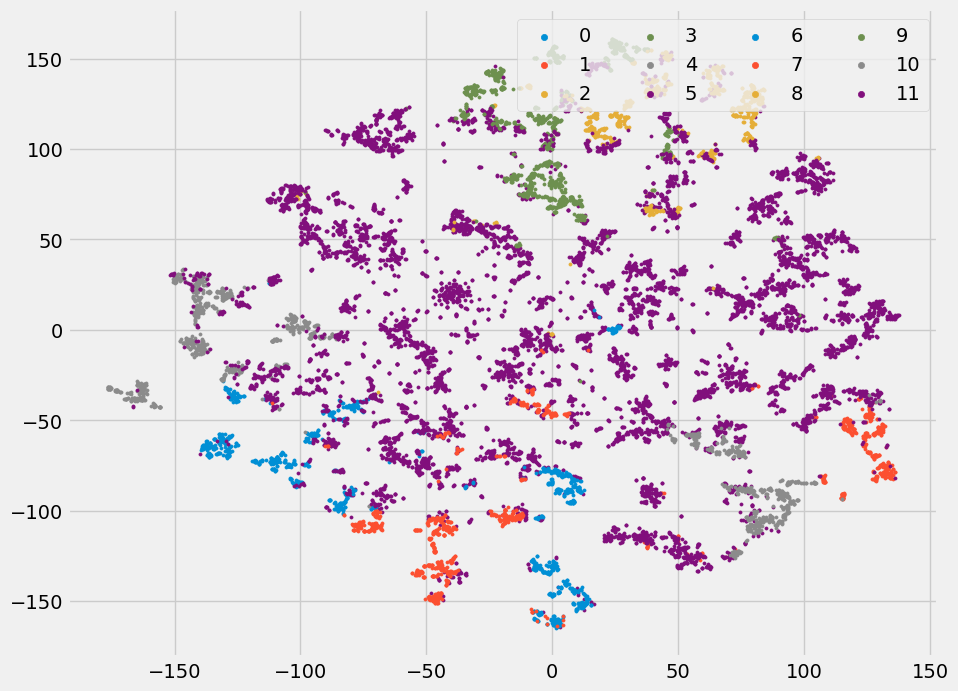

In [73]:
u_labels = range(0,num_clusters)
plt.figure(figsize=(10,8))
 
for i in u_labels:
    plt.scatter(df[df['label']==i]["component1"],df[df['label']==i]["component2"], label = i,
                alpha=1, marker="o", s=5)
plt.legend(ncol=4,loc="upper right",markerscale =2)
plt.savefig(f"{fig_folder}/group_co-topic_cluster.pdf")
plt.show()

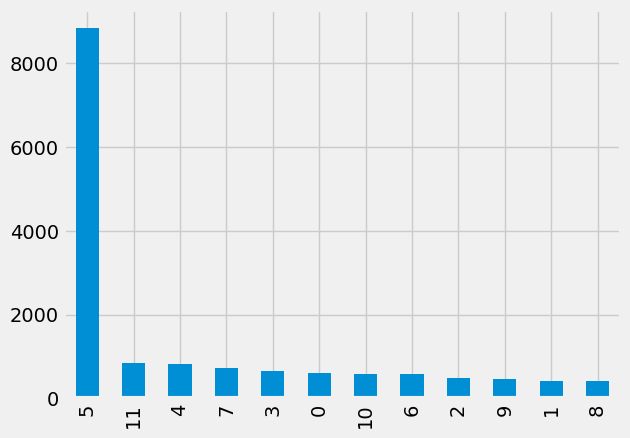

In [74]:
plt.figure()
df['label'].value_counts().plot(kind="bar")
plt.show()

In [75]:
kmeans.cluster_centers_.shape

(12, 100)

In [76]:
kmeans.get_feature_names_out()

array(['kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4', 'kmeans5',
       'kmeans6', 'kmeans7', 'kmeans8', 'kmeans9', 'kmeans10', 'kmeans11'],
      dtype=object)

In [77]:
kmeans.inertia_

61449.537251866954

In [ ]:
# plt.style.use("fivethirtyeight")
# plt.figure(figsize=(8, 8))
# scat = sns.scatterplot(
#      embs[0],
#      embs[1],
#      s=50,
#      data=pcadf,
#      hue="predicted_cluster",
#      style="true_label",
#      palette="Set2",
# )
# scat.set_title(
#     "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# plt.show()

In [303]:
%store -r lda_model
%store -r id2word
%store -r prepare_text_for_lda

In [189]:
from pyfiles.mod_read_researcher_metrics import *
hindex,mgpid2coauthor,mgpid2citation_count,mgpid2publ_count,mgpid2_name_variation,mgpid2_publ_area = get_metrics()

Initial Count: 8727
updated Count: 9128


In [335]:
null_values = np.nan

In [336]:
mod_mgpid2citation_count = {k: v if v > 0 else null_values for k,v in mgpid2citation_count.items()}

In [337]:
mod_mgpid2publ_count     = {k: v if v > 0 else null_values for k,v in mgpid2publ_count.items()}

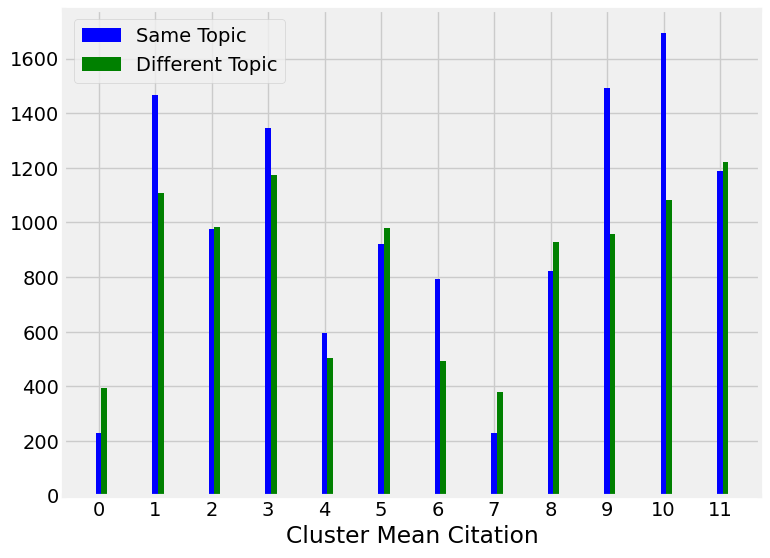

In [345]:
fig, axs = plt.subplots(figsize=(8,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.3)
#axs = axs.ravel()
#etric = "Publication"
Metric = "Citation"
for cluster in range(num_clusters):
    inter_cluster_detail   = get_migration_info1(df)
    group_members = inter_cluster_detail[cluster]["mem_info"]
    same_cluster  = group_members[cluster]
    del group_members[cluster]
    diff_cluster = [member for cluster in group_members for member in cluster]
    same_cluster_citation = [mod_mgpid2citation_count.get(member,null_values) for member in same_cluster]
    diff_cluster_citation = [mod_mgpid2citation_count.get(member,null_values) for member in diff_cluster]
    same_cluster_publ = [mod_mgpid2publ_count.get(member,null_values) for member in same_cluster]
    diff_cluster_publ = [mod_mgpid2publ_count.get(member,null_values) for member in diff_cluster]
    metric = np.nanmean(same_cluster_citation), np.nanmean(diff_cluster_citation)
    #print(cite)
    #metric= np.nanmean(same_cluster_publ), np.nanmean(diff_cluster_publ)
    
    if cluster < 11:
        axs.bar(cluster, metric[0],0.1,color="blue" ) # label=f"Cluster: {cluster}")
        axs.bar(cluster+0.1, metric[1], 0.1,color="green")
    else:
        axs.bar(cluster, metric[0],0.1,color="blue" ,label="Same Topic") # label=f"Cluster: {cluster}")
        axs.bar(cluster+0.1, metric[1], 0.1,color="green", label="Different Topic")
    #axs[cluster].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #axs[cluster].set_ylabel("")#("KL(P || Q)")
axs.legend()
axs.set_xlabel(f"Cluster Mean {Metric}")
plt.xticks(np.arange(num_clusters))
plt.savefig(f"{fig_folder}/cluster_wise_analysis_of_change_in_topic_{Metric}.pdf",bbox_inches="tight")
plt.show()

In [343]:
np.nanmean(same_cluster_publ)

87.18068535825545

In [265]:
# plt.hist(same_cluster_citation, bins=50)
# plt.title("Citation distribution for researchers working in similar topic as their advisor")
# plt.xlabel("Citation values")
# plt.ylabel("Frequency")
# plt.show()

In [266]:
# plt.hist(diff_cluster_citation, bins=50)
# plt.title("Citation distribution for researchers working in different topic as their advisor")
# plt.xlabel("Citation values")
# plt.ylabel("Frequency")
# plt.show()

In [114]:
#diff_cluster

In [80]:
%store -r group_top_topics1

In [82]:
group_top_topics1[18849]

[21, 4, 6, 2, 22]

In [83]:
df.columns

Index(['grp_id', 'grp_member', 'component1', 'component2', 'label',
       'cluster_info', 'cluster_migration', 'cluster_migration1',
       'cluster_migration2', 'cluster_member', 'lbl_mem_id', 'lbl_mem_id1'],
      dtype='object')

In [88]:
from collections import Counter
top_5_topic_cluster= {}
for i in range(num_clusters):
    specific_cluster_df = df[df["label"]==i].copy()
    specific_cluster = []
    for head in specific_cluster_df["grp_id"].values:
        specific_cluster=specific_cluster+group_top_topics1[head]
    topic_freq = Counter(specific_cluster)
    total = sum(topic_freq.values(), 0.0)
    for key in topic_freq:
        topic_freq[key] /= total
    #print(f"Cluster_{i}: {topic_freq}")
    top_5_topic_cluster[i]=[j[0] for j in sorted(dict(topic_freq).items(), key=lambda x: x[1], reverse=True) if j[1]>0.10]

In [86]:
top_5_topic_cluster

{0: [16, 19, 13],
 1: [11, 12, 14],
 2: [2, 21, 3, 5],
 3: [21, 3, 5, 0],
 4: [16, 9],
 5: [],
 6: [6, 19, 10, 18],
 7: [10, 19],
 8: [4, 21, 2],
 9: [20, 3],
 10: [1, 11, 14, 12],
 11: [24, 20, 0]}

In [302]:
top_5_topic_cluster[0], top_5_topic_cluster[5], top_5_topic_cluster[7], top_5_topic_cluster[8]

([16, 19, 13], [], [10, 19], [4, 21, 2])

In [327]:
sorted([(id2word[words[0]], words[1]) for topic in top_5_topic_cluster[0] for words in lda_model.get_topic_terms(topic) if words[1]>0.05],key= lambda x: x[1],reverse=True)

[('model', 0.17612475), ('model', 0.05888113), ('network', 0.052346334)]

In [328]:
sorted([(id2word[words[0]], words[1]) for topic in top_5_topic_cluster[7] for words in lda_model.get_topic_terms(topic) if words[1]>0.05],key= lambda x: x[1],reverse=True)

[('comput', 0.072206385), ('network', 0.052346334)]

In [329]:
sorted([(id2word[words[0]], words[1]) for topic in top_5_topic_cluster[8] for words in lda_model.get_topic_terms(topic) if words[1]>0.05], key= lambda x: x[1],reverse=True)

[('group', 0.115525566), ('algebra', 0.09710922), ('polynomi', 0.07003772)]

In [330]:
sorted([(id2word[words[0]], words[1]) for topic in top_5_topic_cluster[3] for words in lda_model.get_topic_terms(topic) if words[1]>0.05],key= lambda x: x[1],reverse=True)

[('theori', 0.17512259),
 ('group', 0.115525566),
 ('algebra', 0.09710922),
 ('set', 0.08693242),
 ('quantum', 0.06736438),
 ('theorem', 0.056887034),
 ('map', 0.055202316)]

In [331]:
sorted([(id2word[words[0]], words[1]) for topic in top_5_topic_cluster[11] for words in lda_model.get_topic_terms(topic) if words[1]>0.05], key= lambda x: x[1],reverse=True)

[('space', 0.15174271),
 ('function', 0.13187794),
 ('oper', 0.08835124),
 ('set', 0.08693242),
 ('theorem', 0.056887034),
 ('integr', 0.055722155),
 ('map', 0.055202316)]

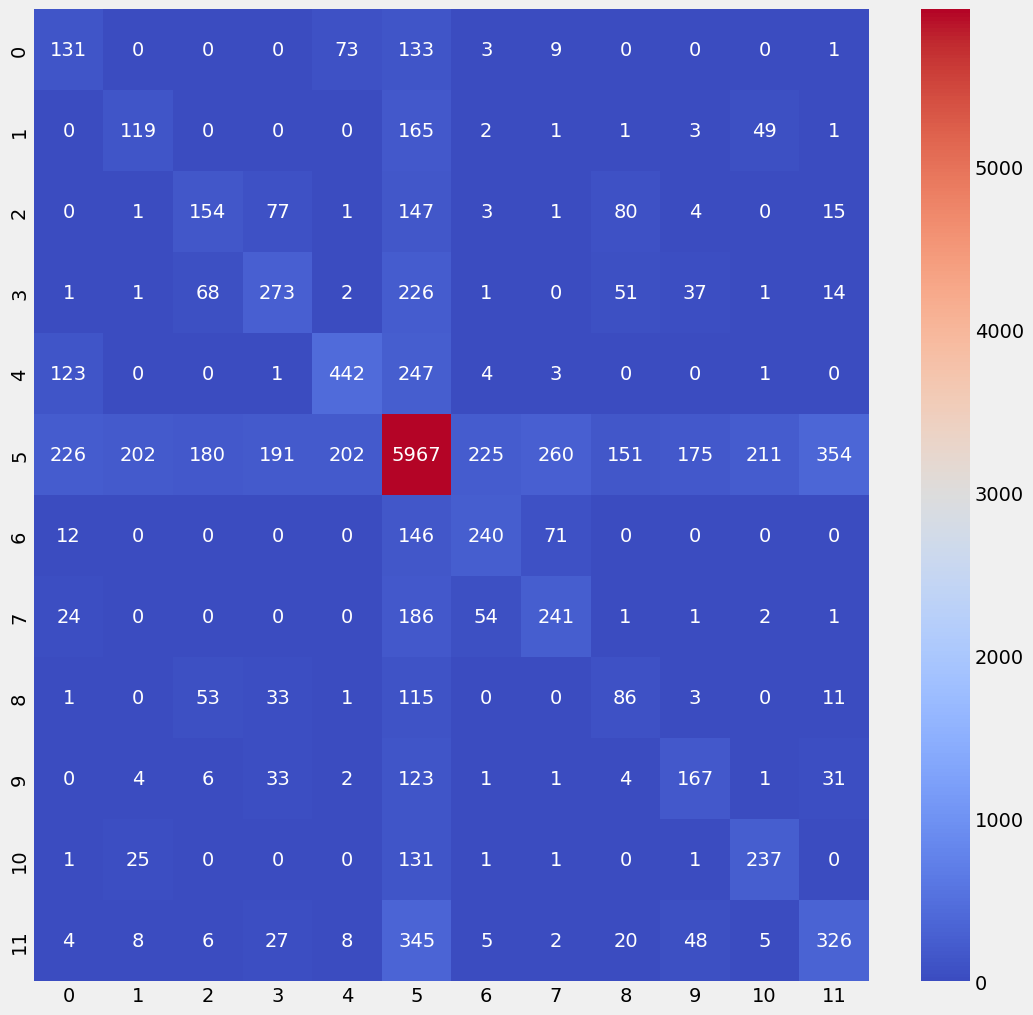

In [87]:
plt.figure(figsize=(12,12))
sns.heatmap(inter_cluster_info,annot=True,cmap="coolwarm", fmt='.4g')
plt.savefig(f"{fig_folder}/inter_cluster_migration.pdf",bbox_inches="tight")
plt.show()